In [1]:
from binvox_rw import *
import numpy as np

In [2]:
with open('model_normalized.solid.binvox', 'rb') as f:
    model = read_as_3d_array(f,fix_coords=True)
    

In [3]:
# Calculate the integrals over all the True voxels

# The data is a numpy array of True or False

def voxel_moment_tensor(data,max_m=5):
    
    M_tensor = np.zeros([max_m,max_m,max_m])
    
    datashape = np.shape(data)
    
    for i in range(max_m):
        for j in range(max_m):
            for k in range(max_m):
                if (i+j+k)<=max_m:
                    for x in range(datashape[0]):
                        for y in range(datashape[1]):
                            for z in range(datashape[2]):
                                if data[x,y,z]:
                                    # Evaluate integral and add to running sum
#                                     M_tensor[i,j,k] +=  ( ((x+1)^(i+1)-(x)^(i+1)) * ((y+1)^(j+1)-(y)^(j+1)) * ((z+1)^(k+1)-(z)^(k+1)) )/( (i+1)*(j+1)*(k+1) )
                                    M_tensor[i,j,k] +=  ( ((x+1)**(i+1)-(x)**(i+1)) * ((y+1)**(j+1)-(y)**(j+1)) * ((z+1)**(k+1)-(z)**(k+1)) )/( (i+1)*(j+1)*(k+1) )
#                                     M_tensor[i,j,k] = M_tensor[i,j,k] + 1
    return M_tensor
                                
                    

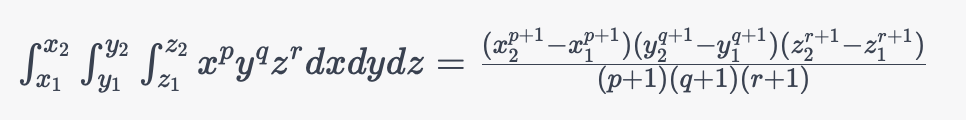

In [4]:
# Calculate the integrals efficiently using Tensor Operations


def voxel_moment_tensor_efficient(data,max_m=5):
    
    M_tensor = np.zeros([max_m,max_m,max_m])
    
    datashape = np.shape(data)
    
    Y,X,Z = np.meshgrid(np.arange(0,datashape[0]),np.arange(0,datashape[1]),np.arange(0,datashape[2]))
    
    X = X*data
    Y = Y*data
    Z = Z*data

    for i in range(max_m):
        for j in range(max_m):
            for k in range(max_m):
                if (i+j+k)<=max_m:
                    M_tensor[i,j,k] = np.sum(
                         ( np.power(X+1,i+1)*data-np.power(X,i+1) )
                        * ( np.power(Y+1,j+1)*data-np.power(Y,j+1) )
                        * ( np.power(Z+1,k+1)*data-np.power(Z,k+1) )
                        / ( (i+1)*(j+1)*(k+1) )
                    )
                    
                    
    return M_tensor
                                
                

In [ ]:
def voxel_moment_tensor_efficient_faster(data,max_m=5):
    
    M_tensor = np.zeros([max_m,max_m,max_m])
    moment_orders = np.arange(max_m)
    
    datashape = np.shape(data)
    
    Y,X,Z = np.meshgrid(np.arange(0,datashape[0]),np.arange(0,datashape[1]),np.arange(0,datashape[2]))
    
    X = X*data
    Y = Y*data
    Z = Z*data
    
    # All these nested loops can be parallelized over i,j,k
    # because this computation is not recursive

    for i in range(max_m):
        for j in range(max_m):
            for k in range(max_m):
                if (i+j+k)<=max_m:
                    M_tensor[i,j,k] = np.sum(
                         ( np.power(X+1,i+1)*data-np.power(X,i+1) )
                        * ( np.power(Y+1,j+1)*data-np.power(Y,j+1) )
                        * ( np.power(Z+1,k+1)*data-np.power(Z,k+1) )
                        / ( (i+1)*(j+1)*(k+1) )
                    )

                    
                    
    return M_tensor

An even more efficient way to do this is to NOT use all the zero voxels, i.e. use the read_as_coord_array() method instead.

Implement the read_coord_array() method instead now for better performance later.

In [5]:
# Efficient calculation, with translation and scale invariance


def voxel_moment_tensor_efficient_t_s_invariant(data,max_m=5):
    
    M_tensor = np.zeros([max_m,max_m,max_m])
    
    datashape = np.shape(data)
    
    Y,X,Z = np.meshgrid(np.arange(0,datashape[0]),np.arange(0,datashape[1]),np.arange(0,datashape[2]))
    
    X = X*data
    Y = Y*data
    Z = Z*data
    
    i = j = k = 0
    scale = np.sum(
                         ( np.power(X+1,i+1)*data-np.power(X,i+1) )
                        * ( np.power(Y+1,j+1)*data-np.power(Y,j+1) )
                        * ( np.power(Z+1,k+1)*data-np.power(Z,k+1) )
                        / ( (i+1)*(j+1)*(k+1) )
                    )
    
    
    i = 1
    j = k = 0
    x_bar = np.sum(
                         ( np.power(X+1,i+1)*data-np.power(X,i+1) )
                        * ( np.power(Y+1,j+1)*data-np.power(Y,j+1) )
                        * ( np.power(Z+1,k+1)*data-np.power(Z,k+1) )
                        / ( (i+1)*(j+1)*(k+1) )
                    ) / scale
    
    j = 1
    i = k = 0
    y_bar = np.sum(
                         ( np.power(X+1,i+1)*data-np.power(X,i+1) )
                        * ( np.power(Y+1,j+1)*data-np.power(Y,j+1) )
                        * ( np.power(Z+1,k+1)*data-np.power(Z,k+1) )
                        / ( (i+1)*(j+1)*(k+1) )
                    ) / scale
    
    k = 1
    i = j = 0
    z_bar = np.sum(
                         ( np.power(X+1,i+1)*data-np.power(X,i+1) )
                        * ( np.power(Y+1,j+1)*data-np.power(Y,j+1) )
                        * ( np.power(Z+1,k+1)*data-np.power(Z,k+1) )
                        / ( (i+1)*(j+1)*(k+1) )
                    ) / scale
    
#     print("Scale: {}".format(scale))
#     print("Centroid: ({},{},{})".format(x_bar,y_bar,z_bar))
    
    X = (X-x_bar)*data
    Y = (Y-y_bar)*data
    Z = (Z-z_bar)*data
    
    

    for i in range(max_m):
        for j in range(max_m):
            for k in range(max_m):
                if (i+j+k)<=max_m:
                    M_tensor[i,j,k] = np.sum(
                         ( np.power(X+1,i+1)*data-np.power(X,i+1) )
                        * ( np.power(Y+1,j+1)*data-np.power(Y,j+1) )
                        * ( np.power(Z+1,k+1)*data-np.power(Z,k+1) )
                    ) / ( (i+1)*(j+1)*(k+1) ) / np.power(scale,(i+j+k+3)/3)
                    
                    
    return M_tensor

In [6]:
# Inspect the scale and translation invariant tensor.
# The 0,0,0 entry should be 1
# The 1,0,0 0,1,0 0,0,1 entries should be ~0

voxel_moment_tensor_efficient_t_s_invariant(model.data,max_m=5)

# Note that performing the scaling and translation twice gives better results!

array([[[ 1.00000000e+00,  2.97214055e-16,  2.24642696e+00,
          4.81800183e-01,  9.75164470e+00],
        [ 3.28006502e-17, -7.02881389e-02, -1.44639242e-01,
         -3.31595945e-01, -7.81413338e-01],
        [ 5.02249955e-02,  1.88604116e-02,  1.02960526e-01,
          9.30365622e-02,  0.00000000e+00],
        [-1.26453561e-03, -1.55011380e-02, -2.37520339e-02,
          0.00000000e+00,  0.00000000e+00],
        [ 9.81394586e-03,  6.33277062e-03,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]],

       [[ 2.00820307e-17, -3.35486865e-03, -3.48791632e-03,
         -2.29033968e-02, -2.65761266e-02],
        [ 4.02737978e-04,  7.21283948e-04,  1.36221285e-03,
          4.89321924e-03,  0.00000000e+00],
        [ 4.18556060e-05, -1.30092430e-04, -5.06270015e-04,
          0.00000000e+00,  0.00000000e+00],
        [-1.17473225e-05,  2.81293890e-05,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 3.68460351e-05,  0.00000000e+00,  0.00000000e+00,
  

In [7]:
def voxel_moment_loss(data_1, data_2, max_m = 3):
    return np.linalg.norm(voxel_moment_tensor_efficient_t_s_invariant(data_1,max_m)-voxel_moment_tensor_efficient_t_s_invariant(data_2,max_m))

In [8]:
voxel_moment_loss(model.data,model.data,max_m=5)

0.0